In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from cnn import FontClassifierCNN
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.nn.utils import clip_grad_norm_
import os
from tqdm import tqdm

c:\Users\weber\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preprocessing

In [2]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(20),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

# Setup Datasets
train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
validation_dataset = datasets.ImageFolder(root='data/validation', transform=transform)

# Setup DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 522, 1042])


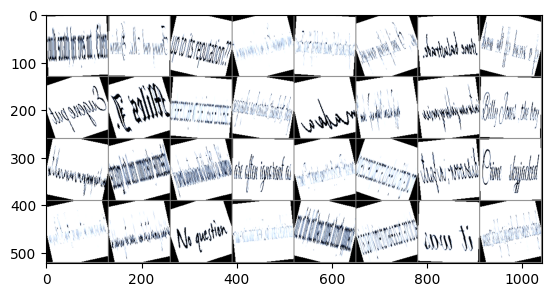

In [3]:
# Validate data loader
def imshow(img):
    print(img.size())
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

### Training Phase

In [4]:
model = FontClassifierCNN()
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.001)
def train_model(model, train_loader, validation_loader, criterion, optimizer, grad_clip = True, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device in use is: {device}")
    model = model.to(device)
    accuracies = []
    for epoch in tqdm(range(num_epochs)):
        model.train() 
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad() 
            outputs = model(inputs) 
            loss = criterion(outputs, labels) 
            loss.backward() 

            if grad_clip:
                clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step() 
            
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1} Training Loss: {epoch_loss:.4f}')

        # Validation phase
        model.eval()
        validation_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = validation_loss / len(validation_loader.dataset)
        epoch_val_accuracy = 100 * correct / total
        accuracies.append(epoch_val_accuracy)
        print(f'Epoch {epoch+1} Validation Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_accuracy:.2f}%')

    return model,accuracies

# Run the training and validation
num_epochs = 80
model_dir = 'model'
model_gradclip,acc_gradclip = train_model(model, train_loader, validation_loader, criterion, optimizer, grad_clip=True,num_epochs = num_epochs)
model,acc = train_model(model, train_loader, validation_loader, criterion, optimizer, grad_clip=False, num_epochs = num_epochs)
model_path = os.path.join(model_dir, 'cnn_grad_clipped.pth')
torch.save(model_gradclip.state_dict(), model_path)
model_path = os.path.join(model_dir, 'cnn.pth')
torch.save(model.state_dict(), model_path)

Device in use is: cpu


100%|██████████| 80/80 [07:23<00:00,  5.54s/it]


Device in use is: cpu


 32%|███▎      | 26/80 [03:29<08:45,  9.73s/it]

### Model Comparison

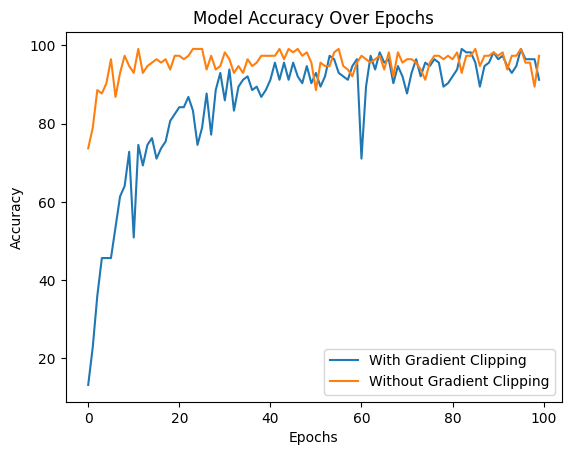

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'num_epochs' is defined and represents the number of epochs
# 'accuracies_grad_clip' and 'accuracies' are arrays/lists of accuracy values per epoch

plt.plot(np.arange(num_epochs), acc_gradclip, label='With Gradient Clipping')
plt.plot(np.arange(num_epochs), acc, label='Without Gradient Clipping')
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis
plt.title('Model Accuracy Over Epochs')  # Title of the plot
plt.legend()  # This adds the legend to the plot
plt.show()  # Display the plot

In [ ]:
model_gradclip = FontClassifierCNN()
model_gradclip.load_state_dict(torch.load('model/cnn_grad_clipped.pth'))
model_gradclip.eval()
correct = 0
total = 0
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
with torch.no_grad():  
    for data in test_loader:
        images, labels = data
        outputs = model_gradclip(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on test data: {accuracy:.2f}%')

Accuracy of the model on test data: 92.86%
